In [1]:
import nltk
from nltk import corpus
from nltk.collocations import *
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk import wordnet
from nltk import punkt
from nltk.util import ngrams
from nltk import FreqDist
#if these last 2 don't work might need to do nltk.download(package)
import re
from bs4 import BeautifulSoup

from string import punctuation
from collections import Counter
import numpy as np

In [2]:
import gensim
from gensim.corpora.dictionary import Dictionary
from gensim.models.tfidfmodel import TfidfModel

import pandas as pd
from datetime import datetime

#Importing sklearn for bigram finder
from sklearn.feature_extraction.text import CountVectorizer

C:\Users\583185\AppData\Local\Continuum\Anaconda3\lib\site-packages\gensim\utils.py:862: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [276]:
import matplotlib.pyplot as plt
import seaborn as sns
import mpld3
from mpld3 import plugins
mpld3.enable_notebook()


# allow plots to appear in the notebook
%matplotlib inline


## Import and Clean Connect Report

In [3]:
report=pd.read_csv('connect_report.csv')

report['Created Date']=pd.to_datetime(report['Created Date'])
report=report[pd.notnull(report['Created Date'])]
report=report[pd.notnull(report['Body'])]

#Removing HTML tags and codes
report['Body'] = report['Body'].apply(lambda x:BeautifulSoup(x))
report['Body'] = report['Body'].apply(lambda x:x.get_text())

#Removing tags/mentions
report['Body'] = report['Body'].apply(lambda x:re.sub('{@[\w\d]*}', '',x))

C:\Users\583185\AppData\Local\Continuum\Anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file C:\Users\583185\AppData\Local\Continuum\Anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


## Report Generator

In [4]:
final_report=pd.DataFrame

#Use this function to create the final report
# Directions:
# 1. Set Group to a list of group names, a single name of a group, or All to use all groups
# 2. Set Type to a specific Feed Item Type or All
# 3. Set Start Date or leave blank(defaults to: )
# 4. Set End Date or leave blank(defaults to: )

def report_generator(Group,Type,Date_start=pd.to_datetime("2017-01-01"),Date_finish=pd.to_datetime('today')):
    if type(Group) == list:
        final_report=report.loc[report['Name'].isin(Group)] 
    elif (Group=='All'):
        final_report=report
    else:
        final_report=report.loc[report['Name']==Group]
                                
    if (Type=='All'):
        final_report=final_report
    else:
        final_report=final_report.loc[final_report['Feed Item Type']==Type]
    
    if(Date_start=="2017-01-01" and Date_finish== pd.to_datetime('today')):
        final_report=final_report
    else:
        Date_start=pd.to_datetime(Date_start, utc=False)
        Date_finish=pd.to_datetime(Date_finish, utc=False)
        #alt approach-- not working but not sure why-- it worked it worked it worked! had to change the data type to all be annoying ass datatime64... down the line that might be a pain but for now it's dope
        final_report=final_report[(final_report['Created Date'] > Date_start) & (final_report['Created Date']< Date_finish)]   
    return(final_report)

final_report=report_generator(['CPC+ All','NLT Internal Users'],'All',"2017-02-01","2017-03-01")

final_report.head(5)

,Network: Name,Name,Created By: Full Name,Created By: Company Name,Body,Created Date,Like Count,Comment Count,Feed Item Type
23,CPC Plus Connect,CPC+ All,Jon Regis,NJ,does everyone have portal access\n,2017-02-02,2.0,47.0,Text Post
24,CPC Plus Connect,CPC+ All,Stephanie Hardin,OH,I am trying to figure out how to document/trac...,2017-02-03,11.0,34.0,Text Post
25,CPC Plus Connect,CPC+ All,Sam Gottuso,BAH,We appreciate your participation in the Care M...,2017-02-03,2.0,4.0,Content Post
26,CPC Plus Connect,CPC+ All,Juliana Fritschel,CO,How is a group created within CPC+ Connect? I ...,2017-02-03,1.0,0.0,Text Post
27,CPC Plus Connect,NLT Internal Users,Bridget Lalley Ryder,NaN,Attention all CPC+ practices! Are there other ...,2017-02-03,0.0,0.0,Link Post


## Tokenizer Function

In [5]:
##Stop word and lemmatizer creation (PLEASE add to stop where you see fit)
stop = stopwords.words('english')
stop.append("cpc+")
stop.append("hi")
stop.append("hello")
stop.append("also")
stop.append("anyone")

wnl = WordNetLemmatizer() 

In [6]:
#this function tokenizes text, removes stop word and punctuation, and lemmatizes the tokens
def tokenizer(text):
 
    tokens_ = [word_tokenize(sent) for sent in sent_tokenize(text.lower())]
    
    tokens = []
    
    for token_by_sent in tokens_:
        tokens += token_by_sent
 
    tokens = list(filter(lambda t: t not in stop, tokens))
    tokens = list(filter(lambda t: t not in punctuation, tokens))
    tokens = list(filter(lambda t: t not in [u"'s", u"n't", u"...", u"''", u'``', u'\u2014', u'\u2026', u'\u2013'], tokens))
     
    filtered_tokens = []
    for token in tokens:
        token = wnl.lemmatize(token)
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
 
    filtered_tokens = list(map(lambda token: token.lower(), filtered_tokens))
 
    return filtered_tokens

In [7]:
#tokenizes final report
final_report['tokens'] = final_report['Body'].map(tokenizer)
#final_report['tokens'][0:10]

In [8]:
##Bi-Grams using Sci-Kit Learn
##Finding bigrams and frequencies across all data

unlisted_report=final_report['tokens'].apply(lambda x: ', '.join(x))

word_vectorizer_2=CountVectorizer(ngram_range=(2,2), analyzer='word')
word_vectorizer_fit_2=word_vectorizer_2.fit_transform(unlisted_report)

frequencies=sum(word_vectorizer_fit_2).toarray()[0]

bigrams_counter=pd.DataFrame(frequencies,index=word_vectorizer_2.get_feature_names(),columns=['frequency'])
f = bigrams_counter[bigrams_counter['frequency']>2]

#The tokenizer cuts it down significantly to 639


##how can we integrate bigrams into the keywords functions-- we have identified the most common ones, how do we match them up with the original body comments?
print(word_vectorizer_fit_2.shape)
print(f[0:10])
#so they produce the same number of rows... but what's the 19354 columns?

(62, 984)
                                frequency
affinity group                          6
benchmark population                    3
care delivery                           3
care management                         7
care team                               3
check latest                            5
collaboration affinity                  4
comprehensiveness coordination          3
entire community                        4
february pm                             3


In [9]:
#extends tokens list with bi-grams for each row
#not lemmatized yet
for i,t in final_report['Body'].iteritems():
    t_list = t.lower().split()
    t_list = list(filter(lambda t: t not in stop, t_list))
    t_list = list(filter(lambda t: t not in punctuation, t_list))
    text=" ".join(t_list)
    
    ng = [ngrams(word_tokenize(sent),2) for sent in sent_tokenize(text.lower())]
    n_gram = []
    for n in ng:
            n_gram += n
    two_grams = []        
    for n in n_gram:
            new = ' '.join(n)
            two_grams.append(new)
    final_report['tokens'][i].extend(two_grams)

## Keyword Retrieval

In [10]:
#this function returns n keywords from specfied token list
def get_keywords(tokens, num):
    return Counter(tokens).most_common(num)

In [11]:
#iterates through all text bodies and prints the raw text and the top 5 most common words
for i,t in final_report['tokens'].iteritems():
    print(final_report['Body'][i])
    print( get_keywords(t,10),"\n")

does everyone have portal access

[('everyone', 1), ('portal', 1), ('access', 1), ('everyone portal', 1), ('portal access', 1)] 

I am trying to figure out how to document/track our use of the CMF payments.  I was wondering if we will just be required to submit an excel document with our expenditures or will additional documentation be required?  I have looked everywhere to find clarification and am not seeing anything.  Any thoughts?  

[('required', 2), ('trying', 1), ('figure', 1), ('document/track', 1), ('use', 1), ('cmf', 1), ('payment', 1), ('wondering', 1), ('submit', 1), ('excel', 1)] 

We appreciate your participation in the Care Management Webinar. Click to download the webinar slides, post additional questions and continue the conversation with others here. A video recording will be forthcoming next week.

[('webinar', 2), ('appreciate', 1), ('participation', 1), ('care', 1), ('management', 1), ('click', 1), ('download', 1), ('slide', 1), ('post', 1), ('additional', 1)] 

Ho

In [12]:
#this functions prints the most common words by Feed Item Type
def keywords_bytype(feed_type):
    tokens = final_report[final_report['Feed Item Type'] == feed_type]['tokens']
    alltokens = []
    for token_list in tokens:
        alltokens += token_list
    counter = Counter(alltokens)
    return counter.most_common(10)

In [13]:
#iterates through all text bodies abd prints most common words by Feed Item Type
for t in set(final_report['Feed Item Type']):
    print('category :', t)
    print('top 10 keywords:', keywords_bytype(t))
    print('---')

category : Advanced Text Post
top 10 keywords: [('announcement', 3), ('important', 2), ('important announcement', 2), ('announcement !', 2), ('test', 1), ('post', 1), ('show', 1), ('side', 1), ('margin', 1), ('feed', 1)]
---
category : Content Post
top 10 keywords: [('webinar', 4), ('check', 4), ('latest', 4), ('newsletter', 4), ('check latest', 4), ('care', 3), ('download', 3), ('slide', 3), ('recording', 3), ('week', 3)]
---
category : Poll
top 10 keywords: [('better', 2), ('link', 2), ('file', 2), ("what 's", 2), ("'s better", 2), ('posting', 1), ('user', 1), ('better link', 1), ('link file', 1), ('file posting', 1)]
---
category : Text Post
top 10 keywords: [('practice', 24), ('patient', 14), ('group', 13), ('care', 11), ('risk', 9), ('portal', 8), ('payment', 8), ('post', 8), ('would', 8), ('report', 8)]
---
category : Link Post
top 10 keywords: [('group', 14), ('practice', 11), ('step', 10), ('health', 9), ('risk', 9), ('click', 7), ('join', 7), ('care', 7), ('patient', 7), ('pay

## TF-IDF

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

# min_df is minimum number of documents that contain a term t
# max_features is maximum number of unique tokens (across documents) that we'd consider
# TfidfVectorizer preprocesses the descriptions using the tokenizer we defined above

In [15]:
#create a vectorizer object for our data with min docs. = 2, max feats. = 10K, and single and paired words
vectorizer = TfidfVectorizer(min_df=2, max_features=10000, tokenizer=tokenizer, ngram_range=(1, 2))
vz = vectorizer.fit_transform(list(final_report['Body']))

In [16]:
#create a dictionary mapping the tokens to their tfidf values
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
tfidf = pd.DataFrame(columns=['tfidf']).from_dict(dict(tfidf), orient='index')
tfidf.columns = ['tfidf']

In [17]:
#low tfidf scores
tfidf.sort_values(by=['tfidf'], ascending=True).head(15)

,tfidf
practice,1.965081
care,2.504077
patient,2.745239
check,2.840550
would,2.945910
group,2.945910
share,2.945910
cm,3.063693
post,3.063693
portal,3.063693


In [18]:
#high tfidf scores
tfidf.sort_values(by=['tfidf'], ascending=False).head(15)

,tfidf
intuition,4.044522
navigation bar,4.044522
next group,4.044522
u input,4.044522
newsletter timely,4.044522
understand,4.044522
new collaboration,4.044522
need assessment,4.044522
update,4.044522
navigation,4.044522


## Correlated Words

In [19]:
##Constructing a collocation finder

finder=BigramCollocationFinder.from_documents(final_report['Body'].apply(tokenizer))
bigram_measures=nltk.collocations.BigramAssocMeasures()
score_collocation=finder.nbest(bigram_measures.pmi,15)

print(score_collocation)


[("'d", 'ask'), ('//app.innovation.cms.gov/cpcplusconnect/sfc/', 'version'), ('aafp', "'risk-stratified"), ('actually', 'create'), ('ago', 'heard'), ('anomaly', 'expect'), ('arkansas', 'blue'), ('around', 'specific'), ('ask', 'well'), ('assume', "'m"), ('athena', 'wanting'), ('awaiting', 'response'), ('based', 'defined'), ('billed', 'sure'), ('blue', 'cross/blue')]


In [20]:
##Using tokens
##use when bi-gram tokens are fixed

finder_2=BigramCollocationFinder.from_documents(final_report['tokens'])
score_collocation_2=finder_2.nbest(bigram_measures.pmi,5)

print(score_collocation_2)

[('# version', 'version ?'), ("' algorithm", 'algorithm .'), ("'' ,", ', read'), ("'' medicare", "medicare 's"), ("'' tab", 'tab ,')]


In [81]:
scored = finder.score_ngrams(bigram_measures.pmi)
sorted_scored=sorted(bigram for bigram, score in scored)

print(sorted_scored[9])

('able', 'assist')


In [82]:
##allows the user to search for two words in the scores list and print the index
def word_finder(x,y):
    for i, v in enumerate(scored):
        if v[0] == (x,y):
            return i
        elif v[0] == (y,x):
            return i

In [93]:
def single_word_finder(x,y,mode='single'):
    scores_e=list(enumerate(scored))
    index_list=[]
    final_list=[]
    if(mode=='double'):
        for i, v in enumerate(scored):
            if v[0] == (x,y):
                return scores_e[i]
            elif v[0] == (y,x):
                return scores_e[i]
    elif(mode=='single'):
        for i, v in enumerate(scored):
            if(scores_e[i][1][0][0]) == x or scores_e[i][1][0][1] == x or scores_e[i][1][0][0]==y or scores_e[i][1][0][1]==y:
                index_list.append(i)
        for j in index_list:
            final_list.append(scores_e[j])
        return final_list
        
        
single_word_finder('management','care','single')

[(484, (('management', 'fee'), 7.329796338220703)),
 (515, (('self', 'management'), 7.329796338220703)),
 (714, (("'risk-stratified", 'care'), 5.937478915441942)),
 (715, (('administrator', 'care'), 5.937478915441942)),
 (716, (('care', 'coordinator'), 5.937478915441942)),
 (717, (('care', 'plan'), 5.937478915441942)),
 (718, (('care', 'redesign'), 5.937478915441942)),
 (719, (('care', 'utilization'), 5.937478915441942)),
 (721, (('experience', 'care'), 5.937478915441942)),
 (722, (('hub', 'care'), 5.937478915441942)),
 (723, (('i.e.', 'care'), 5.937478915441942)),
 (724, (('impression', 'care'), 5.937478915441942)),
 (725, (('include', 'care'), 5.937478915441942)),
 (740, (('pay', 'care'), 5.937478915441942)),
 (741, (('primary', 'care'), 5.937478915441942)),
 (742, (('quarterly', 'care'), 5.937478915441942)),
 (743, (('received', 'care'), 5.937478915441942)),
 (745, (('seam', 'care'), 5.937478915441942)),
 (769, (('care', 'management'), 5.744833837499546)),
 (772, (('management', 'su

In [61]:
##uses the word_finder function to pull out the correlation (or some type of score) between two words

#Actually isn't measuring correlation, but PMI (https://en.wikipedia.org/wiki/Pointwise_mutual_information)... 
#basically it sounds like measures the association that these words aren't just randomly next to each other--- 
#look at the count of each word and then the count of the words together to make the PMI score
try:
    print("The association between the two words is",scored[word_finder("able","assist")][1])
except:
    print("Choose a new word pair!")

The association between the two words is 0.000777000777000777


In [273]:
##Visualizing the results of the bigram finder
def graphing_single_word_finder(word1,word2='',mode='single'):
    graphing_data=single_word_finder(word1,'','single')
    graphing_data=pd.Series(graphing_data)
    score_list=[]
    non_word1_list=[]
    for i,v in graphing_data.iteritems():
        if(graphing_data[i][1][0][0]!=word1):
            non_word1_list.append(graphing_data[i][1][0][0])
        elif(graphing_data[i][1][0][1])!=word1:
            non_word1_list.append(graphing_data[i][1][0][1])
        score_list.append(graphing_data[i][1][1])
    final_graphing=pd.concat([pd.Series(non_word1_list),pd.Series(score_list)],axis=1)
    final_graphing.columns=['Word','PMI_Score']
    word_graph=sns.stripplot(x="Word", y="PMI_Score", data=final_graphing)
    tooltip = plugins.PointLabelTooltip(final_graphing, final_graphing['Word'])
    plugins.connect(word_graph,tooltip)


ValueError: plugins.connect: first argument must be a figure

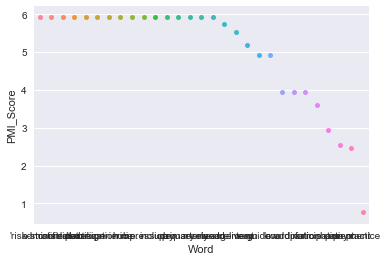

In [277]:
graphing_single_word_finder('care','','single')


#so pretty... have to figure out how to clean up the axis/distingish the dots (tooltip not working)

In [236]:
graphing_data=single_word_finder('care','','single')
graphing_series=pd.Series(graphing_data)

graphing_series[1][1][1]



5.937478915441942